In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import metrics
import torch
import torch.functional as F
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn import metrics

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import MIMIC

# Is the clean source and target task unbiased? Yes

In [58]:
task = 'Edema'
# task = 'Cardiomegaly'
m = MIMIC(task)

In [59]:
m.df[['is_male', task]].corr()

,is_male,Edema
is_male,1.000000,-0.009445
Edema,-0.009445,1.000000


In [64]:
def MI(x, y):
    '''
    mutual information between two binary attributes
    x and y are two equal length list
    '''
    def H(p):
        return - p * np.log(p) - (1-p) * np.log(1-p)
    
    px, py = x.mean(), y.mean()
    py_x, py_notx = y[x==1].mean(), y[x==0].mean()
    return H(py) - (px * H(py_x) + (1-px) * H(py_notx)), H(px), H(py)

mi, ht, hm = MI(m.df[task], m.df['is_male'])
print(mi, ht, hm)
print(f'I({task}; male) = {mi:.2f}, I({task}; male)/H({task}) = {mi/ht:.2f}, I({task}; male)/H(male) = {mi/hm:.2f}')

4.462104700964087e-05 0.6725106982356779 0.6867981495124605
I(Edema; male) = 0.00, I(Edema; male)/H(Edema) = 0.00, I(Edema; male)/H(male) = 0.00


# Data statistics

In [68]:
n_samples = len(np.unique(m.df.subject_id))
n_males = len(np.unique(m.df[m.df.gender=='M'].subject_id))
n_females = len(np.unique(m.df[m.df.gender=='F'].subject_id))
print(f'{len(m.df)} x-rays, {len(np.unique(m.df.pt_id))} studies')
print(f'{n_samples} patients, {n_males} ({n_males/n_samples*100:.2f}%) male, {n_females} ({n_females/n_samples*100:.2f}%) female')

107510 x-rays, 62697 studies
22738 patients, 11307 (49.73%) male, 11431 (50.27%) female


In [66]:
print(f"P({task}) = {m.df[task].mean():.2f}")
print(f"P({task}|male) = {m.df[m.df.gender=='M'][task].mean():.2f}")
print(f"P({task}|female) = {m.df[m.df.gender=='F'][task].mean():.2f}")

P(Edema) = 0.60
P(Edema|male) = 0.60
P(Edema|female) = 0.61


In [55]:
m.df

,Unnamed: 0,index,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,...,Support Devices,local_path,pt_id,split,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,17,35,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50578979,train,10000935,F,52,2182,2008 - 2010,NaN
1,26,52,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,58219844,train,10000935,F,52,2182,2008 - 2010,NaN
2,27,53,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN
3,28,55,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN
4,32,62,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,54935705,train,10000980,F,73,2186,2008 - 2010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107505,425895,729287,-1.0,1.0,1.0,-1.0,1.0,0.0,-1.0,-1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,55683952,train,19998843,M,45,2187,2011 - 2013,NaN
107506,425896,729288,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN
107507,425897,729289,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN
107508,425898,729290,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN


# Threshold to Accuracy and Correlation

In [246]:
def subsample_gender(df, threshold):
    '''
    df is the mimic dataset
    remove male negative and female positive
    '''
    z = np.random.rand(len(df))
    drop = (df['gender'] == 'M') * (df[m.task] == 0) + (df['gender'] == 'F') * (df[m.task] == 1)
    drop = drop * (z <= threshold)
    new_df = df[~drop]
    return new_df
    
subsample_gender(m.df, 1)[['is_male', task]].corr()

,is_male,Edema
is_male,1.0,1.0
Edema,1.0,1.0


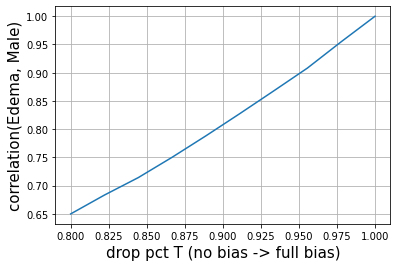

In [247]:
x = np.linspace(0.8, 1, 10)
correlation = [subsample_gender(m.df, t)[['is_male', task]].corr().iloc[0, 1] for t in x]
plt.plot(x, correlation, label=f'correlation({task}, male)')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel(f'correlation({task}, Male)', fontsize=15)
plt.grid()
# plt.legend(fontsize=15)
plt.show()

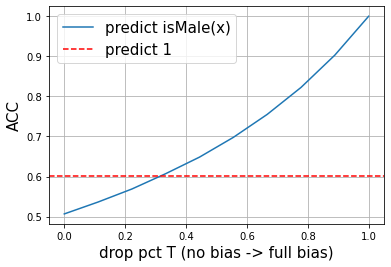

In [248]:
def ACC_male(m, t, task, f):
    '''
    accuracy of using isMale to predict task when subsampling at threshold t
    '''
    df = subsample_gender(m.df, t)
    return f(df[task], df['gender'] == 'M')

reduce_fn = metrics.accuracy_score
x = np.linspace(0, 1, 10)
acc = [ACC_male(m, t, task, reduce_fn) for t in x]
plt.plot(x, acc, label='predict isMale(x)')
plt.axhline(reduce_fn(m.df[task], np.ones_like(m.df[task])), ls='--', color='r', label='predict 1')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel('ACC', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

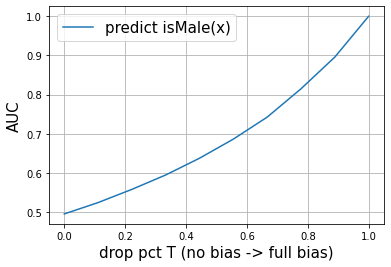

In [249]:
reduce_fn = metrics.roc_auc_score
x = np.linspace(0, 1, 10)
acc = [ACC_male(m, t, task, reduce_fn) for t in x]
plt.plot(x, acc, label='predict isMale(x)')
# plt.axhline(reduce_fn(m.df[task], np.ones_like(m.df[task])), ls='--', color='r', label='predict 1')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel('AUC', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

# Results

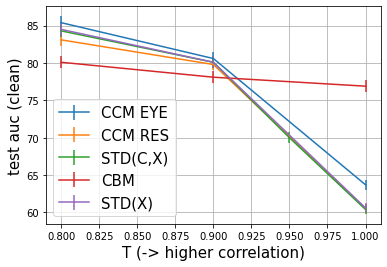

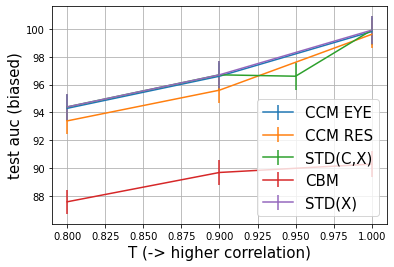

In [120]:
# key is dim_noise, value is [clean acc, t=1]
perf_dict_cbm = {
    1.0: [76.9, 90.3, 67.3],
    0.9: [78.1, 89.7, 65.9],
    0.8: [80.1, 87.6, 63.4]
}
perf_dict_alpha = { # EYE
    0.8: [85.4, 94.3],
    # 0.9: [81.3, 95.4], # 0.1
    0.9: [80.6, 96.6], # full batch [80.5, 96.4] 
    # 1.0: [73.2, 94.7],
    1.0: [63.7, 99.8],
}
perf_dict_std = { # alpha=0
    0.8: [84.3, 94.4],
    0.9: [80.1, 96.7], # small batch
    0.95: [70.0, 96.6],
    1.0: [60.4, 99.9]
}
perf_dict_ccmr = {
    0.8: [83.1, 93.4],
    0.9: [79.8, 95.6],
    1.0: [60.5, 99.6]
}
perf_dict_stdx = {    
    0.8: [84.5, 94.4, 76.7],
    0.9: [80.1, 96.7, 85.5],
    # 0.9: [79.8, 96.6], larger batch
    1.0: [60.6, 99.9, 99.2]
}

def select_list(l, *args):
    return [l[a] for a in args]

def report_latex(name, d, fmt='.1f'):
    res = [name]
    for a in d:
        l, h = get_error(a/100.0)
        res.append(f"{a:{fmt}} ({l*100:{fmt}}, {h*100:{fmt}})")

    print(" & ".join(res))

def get_error(p, n=100):
    '''bootstrap'''
    assert 0 <= p <= 1, "probablity is non-negative"
    n_test = 32 * 672 # 374
    a, b = np.percentile([sum(np.random.choice(2, n_test, p=[1-p, p])) / float(n_test) for _ in range(n)], [2.5, 97.5])
    return a, b


def plot_d_noise(d, dim=0, label=None):
    x = d.keys()
    y = list(map(lambda x: x[dim], d.values()))
    # plt.plot(x, y, label=label)
    yerr = list(zip(*[get_error(a/100.0) for a in y]))
    plt.errorbar(x, y, yerr=yerr, label=label)

xlabel = "T (-> higher correlation)"

plot_d_noise(perf_dict_alpha, 0, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 0, "CCM RES")
plot_d_noise(perf_dict_std, 0, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 0, "CBM")
plot_d_noise(perf_dict_stdx, 0, "STD(X)")
plt.ylabel('test auc (clean)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

plot_d_noise(perf_dict_alpha, 1, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 1, "CCM RES")
plot_d_noise(perf_dict_std, 1, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 1, "CBM")
plot_d_noise(perf_dict_stdx, 1, "STD(X)")
plt.ylabel('test auc (biased)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

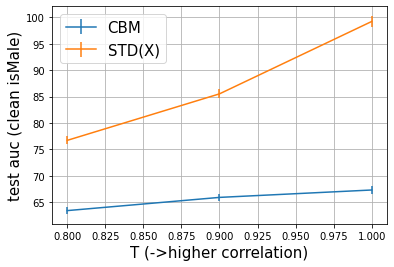

In [118]:
xlabel = "T (->higher correlation)"

plot_d_noise(perf_dict_cbm, 2, "CBM")
plot_d_noise(perf_dict_stdx, 2, "STD(X)")
plt.ylabel('test auc (clean isMale)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()


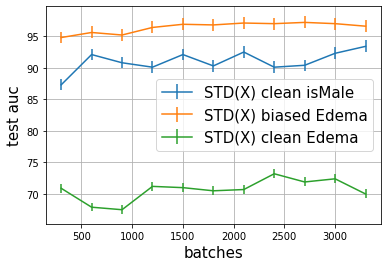

In [39]:
perf_dict_stdx = {
    300*1: [94.8, 70.9, 87.3], # save every 300 batches corresponds to outputs/standard_0.pt
    300*2: [95.6, 67.9, 92.1], # outputs/standard_1.pt
    300*3: [95.2, 67.5, 90.8],
    300*4: [96.4, 71.2, 90.1],
    300*5: [96.9, 71.0, 92.1],
    300*6: [96.8, 70.5, 90.3],
    300*7: [97.1, 70.7, 92.5],
    300*8: [97.0, 73.2, 90.1],
    300*9: [97.2, 71.9, 90.4],
    300*10: [97.0, 72.4, 92.3],
    300*11: [96.6, 70.0, 93.4]
}

xlabel = "batches"

plot_d_noise(perf_dict_stdx, 2, "STD(X) clean isMale")
plot_d_noise(perf_dict_stdx, 0, "STD(X) biased Edema")
plot_d_noise(perf_dict_stdx, 1, "STD(X) clean Edema")
plt.ylabel('test auc', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()


# Per group investigation

In [255]:
fn = '../outputs/7b0a1aac4b6111ecb773ac1f6b24a434/ccm_Edema.npz'
# fn = '../outputs/5a4ce99a4b3711ecb773ac1f6b24a434/standard_Edema.npz'
# fn = '../outputs/5df7a9fe4b3711ecb773ac1f6b24a434/cbm_Edema.npz'
task = fn.split('/')[-1].split('_')[-1].split('.')[0]
output = torch.load(fn)
m = MIMIC(task)
print(output.shape) # 200 is a mistake but it shouldn't change the result in any way
m.df['output'] = softmax(output, 1)[:, 1]

317410 unknown Edema value in mimic data
(107510, 200)


In [256]:
indices = list(range(len(m)))
labels = list(m.df[task])
_, test_indices = train_test_split(indices, stratify=labels, random_state=42)
m_test = m.df.iloc[test_indices]
m_test[[task, 'is_male', 'output']].mean()

Edema      0.601235
is_male    0.553836
output     0.574208
dtype: float64

In [257]:
print('average softmax prediction Male   Edema=1: {:.2f}'.format(m_test[(m_test['is_male']==1) * (m_test[task]==1)]['output'].mean()))
print('average softmax prediction Male   Edema=0: {:.2f}'.format(m_test[(m_test['is_male']==1) * (m_test[task]==0)]['output'].mean()))
print('average softmax prediction Female Edema=1: {:.2f}'.format(m_test[(m_test['is_male']==0) * (m_test[task]==1)]['output'].mean()))
print('average softmax prediction Female Edema=0: {:.2f}'.format(m_test[(m_test['is_male']==0) * (m_test[task]==0)]['output'].mean()))

average softmax prediction Male   Edema=1: 0.85
average softmax prediction Male   Edema=0: 0.54
average softmax prediction Female Edema=1: 0.54
average softmax prediction Female Edema=0: 0.16


In [259]:
metric = metrics.roc_auc_score
y, yhat = m_test[task], m_test['output']
print(f'AUC {task}:', metric(y, yhat))

t = 0.9
m_sub = subsample_gender(m_test, t)
y, yhat = m_sub[task], m_sub['output']
print(f'AUC {task} T={t}:', metric(y, yhat))

y, yhat = m_test['is_male'], m_test['output']
print(f'AUC is_male:', metric(y, yhat))

# y, yhat = m_test[m_test['is_male']==1][task], m_test[m_test['is_male']==1]['output']
# print(f'AUC {task} for male:', metric(y, yhat))

# y, yhat = m_test[m_test['is_male']==0][task], m_test[m_test['is_male']==0]['output']
# print(f'AUC {task} for female:', metric(y, yhat))

AUC Edema: 0.8084173051856874
AUC Edema T=0.9: 0.9667530621317024
AUC is_male: 0.8139296276786969


In [260]:
y, yhat = m_test[task], m_test['output']
print(f'ACC {task}:', (y == (yhat > 0.5)).mean())

y, yhat = m_test['is_male'], m_test['output']
print(f'ACC is_male:', (y == (yhat > 0.5)).mean())

y, yhat = m_test[m_test['is_male']==1][task], m_test[m_test['is_male']==1]['output']
print(f'ACC {task} for male:', (y == (yhat > 0.5)).mean())

y, yhat = m_test[m_test['is_male']==0][task], m_test[m_test['is_male']==0]['output']
print(f'ACC {task} for female:', (y == (yhat > 0.5)).mean())

ACC Edema: 0.7389314681151872
ACC is_male: 0.7264305379864573
ACC Edema for male: 0.7478167405616015
ACC Edema for female: 0.7279019346230821


In [199]:
metrics.roc_auc_score(m_test['is_male'], m_test['output'])

0.8368912804469851

In [200]:
q0, q1, q2, q3 = np.percentile(m_test['output'], [0, 25, 50, 75])

In [201]:
m_test[(m_test['output'] >= q0) * (m_test['output'] <= q1)][[task, 'is_male', 'output']].mean()

Edema      0.247917
is_male    0.168304
output     0.047949
dtype: float64

In [202]:
m_test[(m_test['output'] >= q1) * (m_test['output'] <= q2)][[task, 'is_male', 'output']].mean()

Edema      0.532222
is_male    0.440839
output     0.462149
dtype: float64

In [203]:
m_test[(m_test['output'] >= q2) * (m_test['output'] <= q3)][[task, 'is_male', 'output']].mean()

Edema      0.717220
is_male    0.688942
output     0.917055
dtype: float64

In [204]:
m_test[(m_test['output'] >= q3)][[task, 'is_male', 'output']].mean()

Edema      0.907589
is_male    0.917262
output     0.995925
dtype: float64

In [232]:
mi, ht, hm = MI(m_test[task], m_test['is_male'])
print(f'I({task}; male) = {mi:.2f}, I({task}; male)/H({task}) = {mi/ht:.2f}, I({task}; male)/H(male) = {mi/hm:.2f}')
m_test[['is_male', task]].corr()

I(Edema; male) = 0.00, I(Edema; male)/H(Edema) = 0.00, I(Edema; male)/H(male) = 0.00


,is_male,Edema
is_male,1.000000,-0.010851
Edema,-0.010851,1.000000
